
## CSE 572 HW2 - Titanic Modeling

This notebook reuses the HW1 preprocessing pipeline and extends it with model tuning and evaluation required for HW2 Task 1.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [2]:
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)
train_path = DATA_DIR / 'train.csv'

if not train_path.exists():
    import urllib.request
    url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
    urllib.request.urlretrieve(url, train_path)

raw_df = pd.read_csv(train_path)
print(f'Training shape: {raw_df.shape}')
raw_df.head()

Training shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:

def preprocess_titanic(df):
    df = df.copy()
    df = df.drop(['Ticket', 'Cabin'], axis=1)

    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping).fillna(0).astype(int)

    df = df.drop(['Name'], axis=1)
    if 'PassengerId' in df.columns:
        df = df.drop(['PassengerId'], axis=1)

    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    guess_ages = np.zeros((2, 3))
    overall_age_median = df['Age'].median()

    for i in range(2):
        for j in range(3):
            mask = (df['Sex'] == i) & (df['Pclass'] == j + 1)
            guess_df = df.loc[mask, 'Age'].dropna()
            if guess_df.empty:
                age_guess = overall_age_median
            else:
                age_guess = guess_df.median()
            guess = int(age_guess / 0.5 + 0.5) * 0.5
            guess_ages[i, j] = guess
            df.loc[mask & df['Age'].isna(), 'Age'] = guess

    df['Age'] = df['Age'].fillna(overall_age_median)
    df['Age'] = df['Age'].astype(int)

    df.loc[df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[df['Age'] > 64, 'Age'] = 4

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df = df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

    df['Age*Class'] = df['Age'] * df['Pclass']

    freq_port = df['Embarked'].dropna().mode()[0]
    df['Embarked'] = df['Embarked'].fillna(freq_port)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    df['Fare'] = df['Fare'].fillna(df['Fare'].dropna().median())
    df['Fare'] = pd.qcut(df['Fare'], 4, labels=False, duplicates='drop').astype(int)

    return df

processed_df = preprocess_titanic(raw_df)
processed_df.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [4]:
X = processed_df.drop('Survived', axis=1)
y = processed_df['Survived']
X.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsAlone',
       'Age*Class'],
      dtype='object')

In [5]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(dt, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X, y)
best_dt = dt_grid.best_estimator_
print('Best Decision Tree params:', dt_grid.best_params_)
print('Grid search mean accuracy:', dt_grid.best_score_)

Best Decision Tree params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid search mean accuracy: 0.8170799070993662


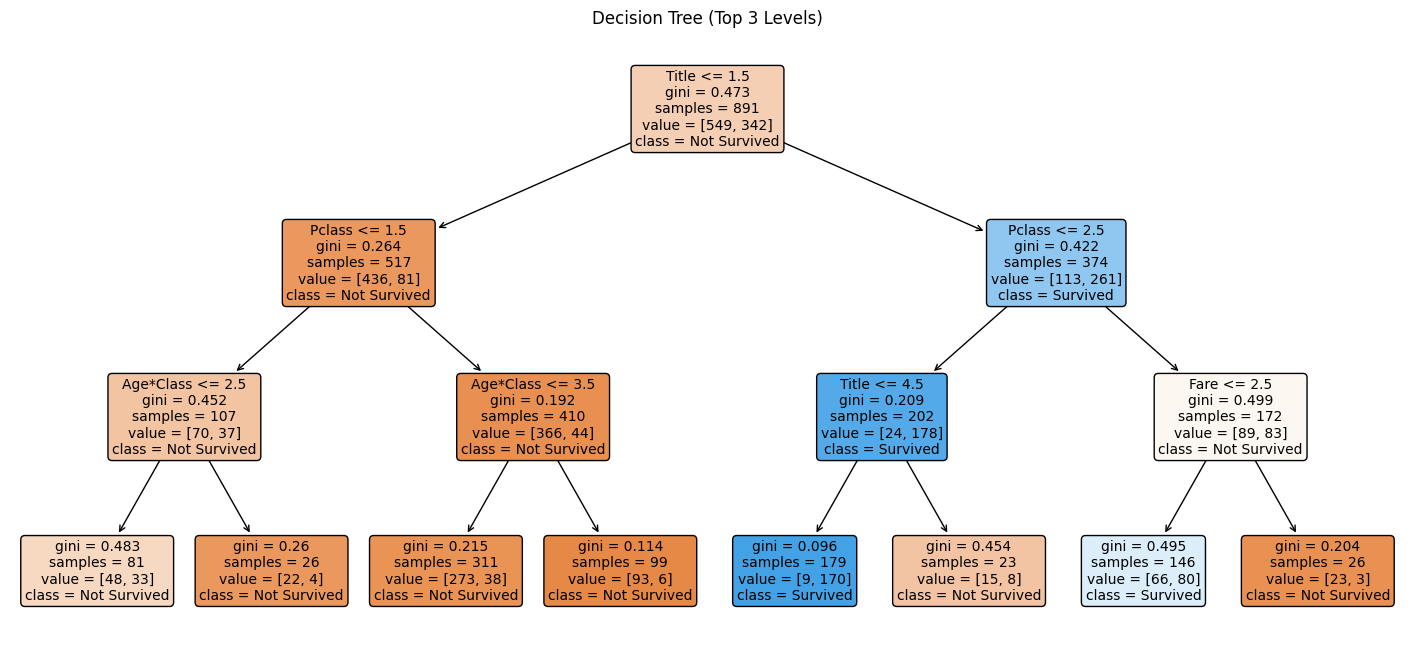

In [6]:
plt.figure(figsize=(18, 8))
plot_tree(best_dt, feature_names=X.columns, class_names=['Not Survived', 'Survived'],
          filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title('Decision Tree (Top 3 Levels)')
plt.show()

In [7]:
try:
    from sklearn.tree import export_graphviz
    import graphviz
    dot = export_graphviz(best_dt, out_file=None,
        feature_names=X.columns, class_names=['Not Survived', 'Survived'],
        filled=True, rounded=True, special_characters=True, max_depth=3)
    graphviz.Source(dot)
except Exception as e:
    print("Graphviz fallback unavailable:", e)

In [8]:
dt_cv_scores = cross_val_score(best_dt, X, y, cv=cv, scoring='accuracy')
print('Decision Tree 5-fold accuracies:', dt_cv_scores)
print(f'Decision Tree mean accuracy: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}')

Decision Tree 5-fold accuracies: [0.79888268 0.80898876 0.85955056 0.78651685 0.83146067]
Decision Tree mean accuracy: 0.8171 ± 0.0259


In [9]:
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}
rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X, y)
best_rf = rf_grid.best_estimator_
print('Best Random Forest params:', rf_grid.best_params_)
print('Random Forest grid search mean accuracy:', rf_grid.best_score_)

Best Random Forest params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest grid search mean accuracy: 0.8238152030632101


In [10]:
rf_cv_scores = cross_val_score(best_rf, X, y, cv=cv, scoring='accuracy')
print('Random Forest 5-fold accuracies:', rf_cv_scores)
print(f'Random Forest mean accuracy: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}')

Random Forest 5-fold accuracies: [0.80446927 0.8258427  0.85393258 0.78651685 0.84831461]
Random Forest mean accuracy: 0.8238 ± 0.0256


## HW2 – Task 1 Results (5-Fold CV)
- Tuned Decision Tree (best params + 5-fold CV)
- Random Forest (grid search + 5-fold CV)
- Comparison summary below

In [11]:
print(f"Decision Tree 5-fold CV: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}")
print(f"Random Forest 5-fold CV: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
if rf_cv_scores.mean() > dt_cv_scores.mean():
    print("→ Random Forest performed better (variance reduction via bagging + feature subsampling).")
else:
    print("→ Decision Tree performed similarly or better (dataset small/homogeneous).")

Decision Tree 5-fold CV: 0.8171 ± 0.0259
Random Forest 5-fold CV: 0.8238 ± 0.0256
→ Random Forest performed better (variance reduction via bagging + feature subsampling).



The cross-validation metrics captured above can be used in the PDF report for Task 1. Combine the reported accuracies with qualitative observations to compare Decision Tree and Random Forest models.
